# Categorical Deep Q Network (C51)

## Imports

In [1]:
import gym, math, glob, random
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from utils.wrappers import *
from agents.DQN import Model as DQN_Agent
from utils.ReplayMemory import ExperienceReplayMemory

from utils.hyperparameters import Config
from utils.plot import plot_all_data

## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = config.device

#epsilon variables
config.epsilon_start = 1.0
config.epsilon_final = 0.01
config.epsilon_decay = 90000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 100000
config.BATCH_SIZE = 32

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=1000000
config.UPDATE_FREQ = 1

#Nstep controls
config.N_STEPS=1

#Categorical Params
config.ATOMS = 51
config.V_MAX = 10
config.V_MIN = -10

## Network

In [3]:
class CategoricalDQN(nn.Module):
    def __init__(self, input_shape, num_actions, atoms=51):
        super(CategoricalDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.atoms = atoms

        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(self.feature_size(), 512)
        self.fc2 = nn.Linear(512, self.num_actions*self.atoms)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x.view(-1, self.num_actions, self.atoms), dim=2)
    
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)

## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/gym'):
        self.atoms = config.ATOMS
        self.v_max = config.V_MAX
        self.v_min = config.V_MIN
        self.supports = torch.linspace(self.v_min, self.v_max, self.atoms).view(1, 1, self.atoms).to(config.device)
        self.delta = (self.v_max - self.v_min) / (self.atoms - 1)

        super(Model, self).__init__(static_policy, env, config, log_dir=log_dir)
    
    def declare_networks(self):
        self.model = CategoricalDQN(self.num_feats, self.num_actions, atoms=self.atoms)
        self.target_model = CategoricalDQN(self.num_feats, self.num_actions, atoms=self.atoms)
        
    def projection_distribution(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        with torch.no_grad():
            max_next_dist = torch.zeros((self.batch_size, 1, self.atoms), device=self.device, dtype=torch.float) + 1. / self.atoms
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                max_next_dist[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action)
                max_next_dist = max_next_dist.squeeze()

            Tz = batch_reward.view(-1, 1) + (self.gamma**self.nsteps) * self.supports.view(1, -1) * non_final_mask.to(torch.float).view(-1, 1)
            Tz = Tz.clamp(self.v_min, self.v_max)
            b = (Tz - self.v_min) / self.delta
            l = b.floor().to(torch.int64)
            u = b.ceil().to(torch.int64)
            l[(u > 0) * (l == u)] -= 1
            u[(l < (self.atoms - 1)) * (l == u)] += 1
            
            offset = torch.linspace(0, (self.batch_size - 1) * self.atoms, self.batch_size).unsqueeze(dim=1).expand(self.batch_size, self.atoms).to(batch_action)
            m = batch_state.new_zeros(self.batch_size, self.atoms)
            m.view(-1).index_add_(0, (l + offset).view(-1), (max_next_dist * (u.float() - b)).view(-1))  # m_l = m_l + p(s_t+n, a*)(u - b)
            m.view(-1).index_add_(0, (u + offset).view(-1), (max_next_dist * (b - l.float())).view(-1))  # m_u = m_u + p(s_t+n, a*)(b - l)

        return m
    
    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        batch_action = batch_action.unsqueeze(dim=-1).expand(-1, -1, self.atoms)
        batch_reward = batch_reward.view(-1, 1, 1)

        # estimate
        current_dist = self.model(batch_state).gather(1, batch_action).squeeze()

        target_prob = self.projection_distribution(batch_vars)
          
        loss = -(target_prob * current_dist.log()).sum(-1)
        loss = loss.mean()

        return loss
    
    def get_action(self, s, eps):
        with torch.no_grad():
            if np.random.random() >= eps or self.static_policy:
                X = torch.tensor([s], device=self.device, dtype=torch.float) 
                a = self.model(X) * self.supports
                a = a.sum(dim=2).max(1)[1].view(1, 1)
                return a.item()
            else:
                return np.random.randint(0, self.num_actions)
            
    def get_max_next_state_action(self, next_states):
        next_dist = self.target_model(next_states) * self.supports
        return next_dist.sum(dim=2).max(1)[1].view(next_states.size(0), 1, 1).expand(-1, -1, self.atoms)

## Training Loop

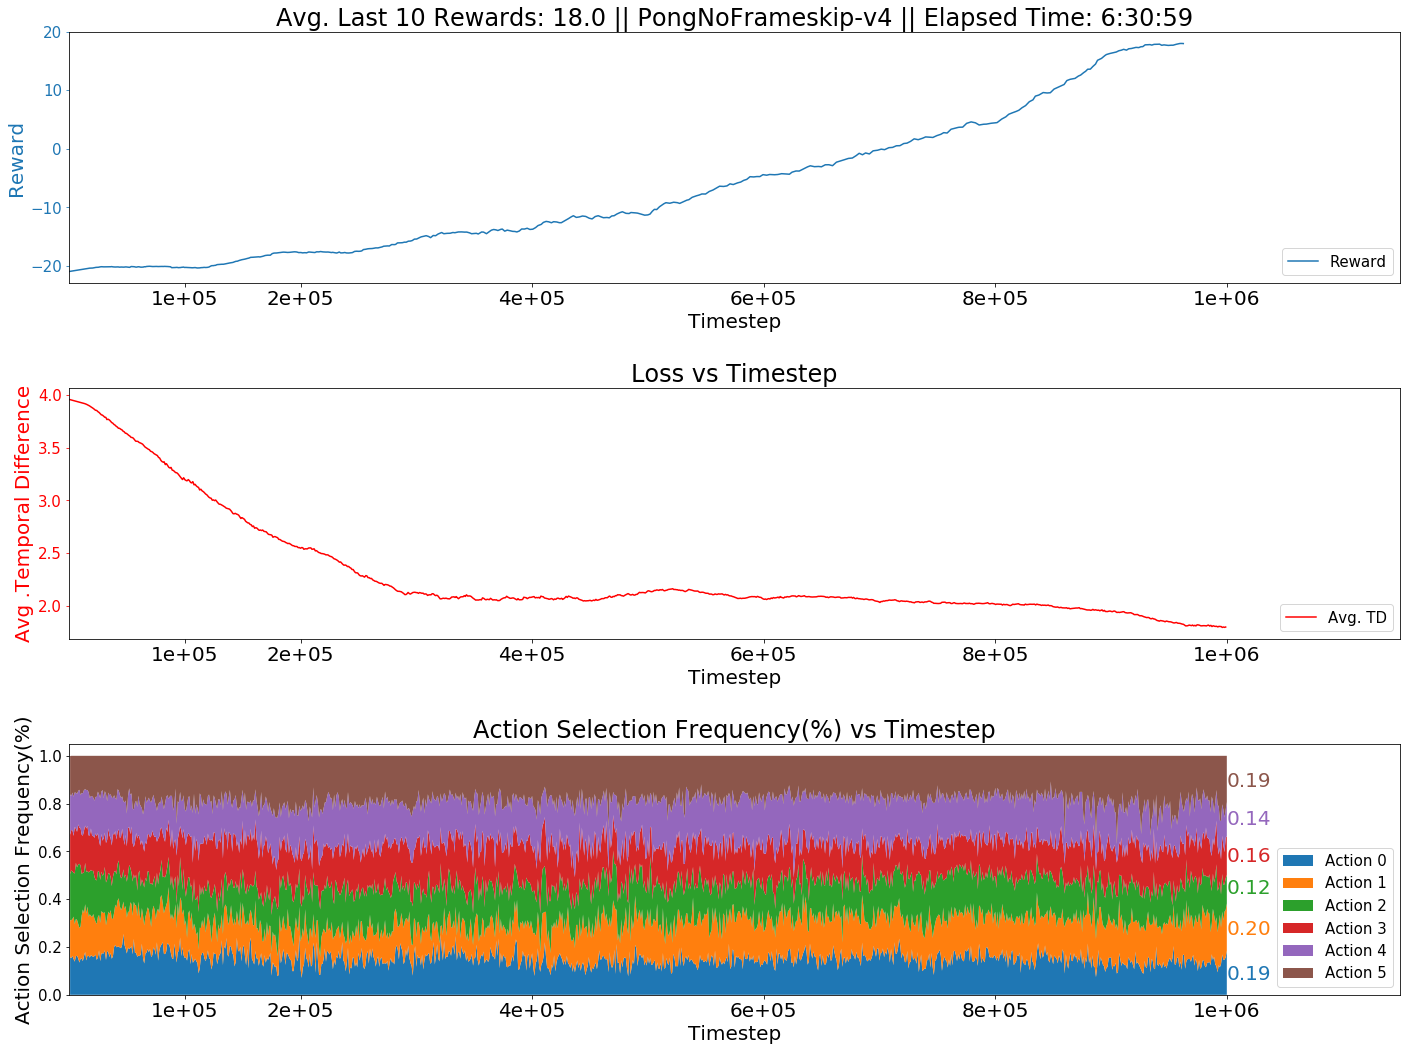

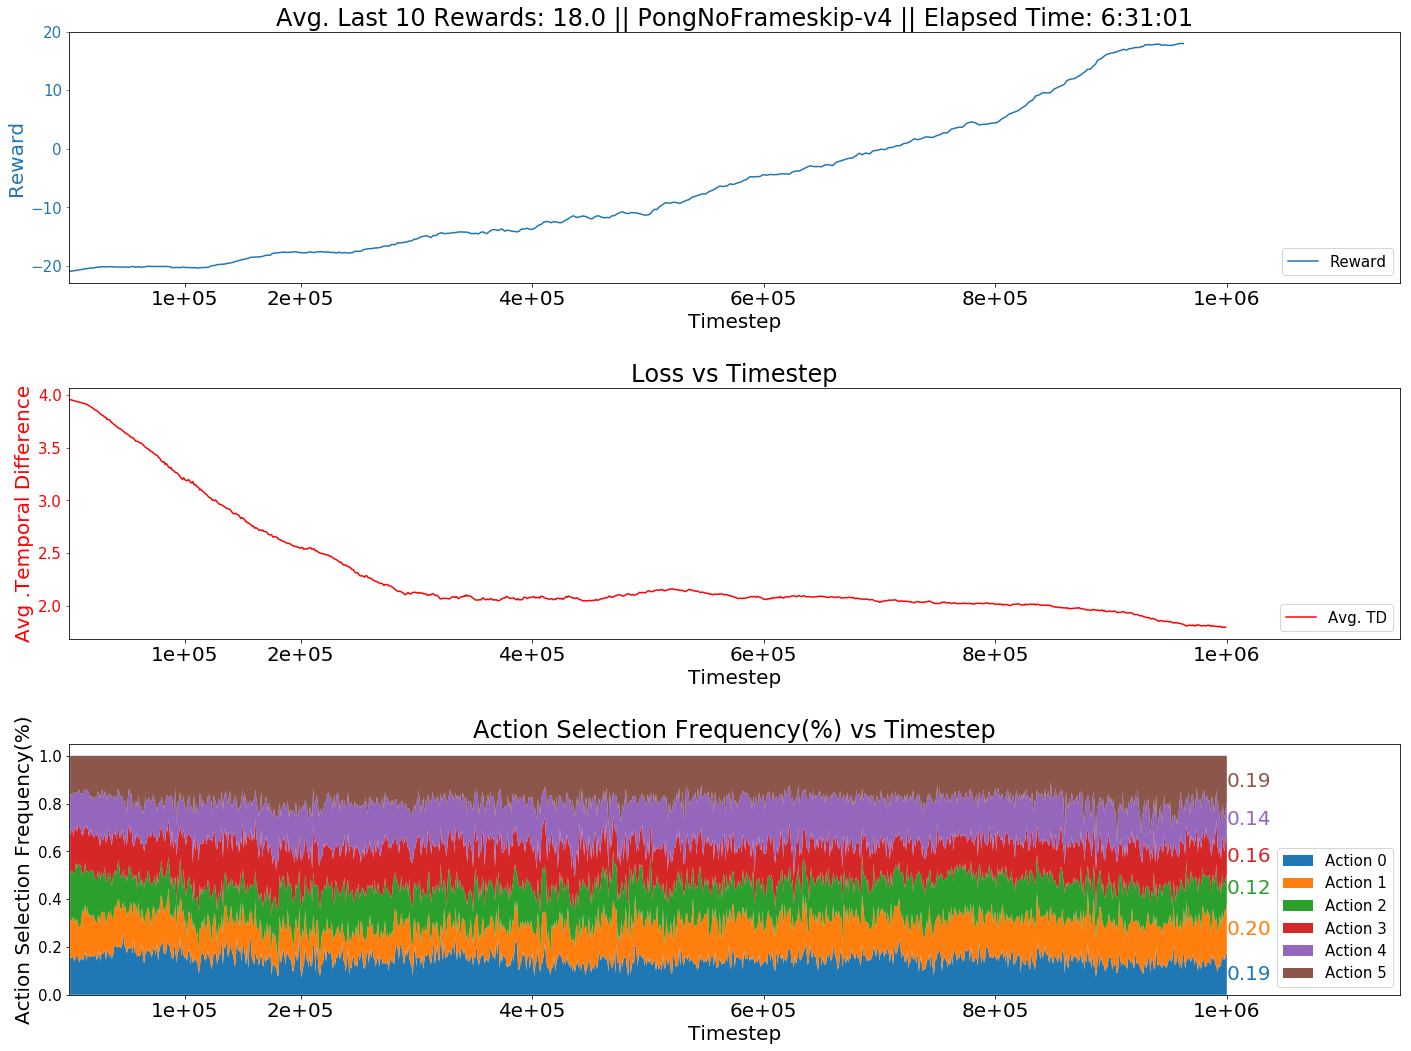

In [5]:
start=timer()

log_dir = "/tmp/gym/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = bench.Monitor(env, os.path.join(log_dir, env_id))
env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=True)
env    = WrapPyTorch(env)
model  = Model(env=env, config=config, log_dir=log_dir)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    model.save_action(action, frame_idx) #log action selection

    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0

    if frame_idx % 10000 == 0:
        model.save_w()
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'C51', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()
plot_all_data(log_dir, env_id, 'C51', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)